In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens100k/movies.csv
/kaggle/input/movielens100k/ratings.csv
/kaggle/input/movielens100k/u.data
/kaggle/input/movielens100k/tags.csv
/kaggle/input/movielens100k/links.csv


In [2]:
import pandas as pd

# Step 1: Download and load the MovieLens 100k dataset
movie_lens_data = pd.read_csv('/kaggle/input/movielens100k/ratings.csv')

In [3]:
# Step 2: Explore the dataset
# Enumerate the columns
columns = movie_lens_data.columns
print("Columns:", columns)

Columns: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [4]:
# Check the number of users, items, and ratings
num_users = movie_lens_data['userId'].nunique()
num_items = movie_lens_data['movieId'].nunique()
num_ratings = len(movie_lens_data)
print(num_users)
print(num_items)
print(num_ratings)

671
9066
100004


In [5]:
# Number of ratings of each user
ratings_per_user = movie_lens_data.groupby('userId').size()
print(len(ratings_per_user))

671


In [6]:
# Average number of ratings per user
avg_ratings_per_user = ratings_per_user.mean()
print(avg_ratings_per_user)

149.03725782414307


In [7]:
# Number of items per item
ratings_per_item = movie_lens_data.groupby('movieId').size()
print(ratings_per_item)

movieId
1         247
2         107
3          59
4          13
5          56
         ... 
161944      1
162376      1
162542      1
162672      1
163949      1
Length: 9066, dtype: int64


In [8]:
# Average number of ratings per item
avg_ratings_per_item = ratings_per_item.mean()
print(avg_ratings_per_item)

11.030664019413193


In [9]:
import numpy as np

def RSelection(data, p):
    """
    Randomly select a portion 'p' of the input data with equal selection probability for each rating.

    Parameters:
    - data: DataFrame, the input data containing ratings
    - p: float, the portion of data to be selected (0 <= p <= 1)

    Returns:
    - selected_data: DataFrame, the randomly selected portion of the input data
    """
    # Validate the input portion 'p'
    if not 0 <= p <= 1:
        raise ValueError("Invalid value for 'p'. It should be between 0 and 1.")

    # Calculate the total number of ratings
    total_ratings = len(data)

    # Calculate the number of ratings to select
    num_ratings_to_select = int(total_ratings * p)

    # Generate random indices for selecting ratings
    random_indices = np.random.choice(total_ratings, num_ratings_to_select, replace=False)

    # Select the portion of data based on random indices
    selected_data = data.iloc[random_indices]

    return selected_data

# Example usage:
# Assuming you have a DataFrame 'movie_lens_data' from the MovieLens dataset
# You can use the RSelection method as follows:
selected_portion = RSelection(movie_lens_data, 0.2)  # Selects 20% of the data randomly
print(selected_portion)


       userId  movieId  rating   timestamp
62000     452     2527     3.0   976424003
82559     562     2791     4.0  1167429094
69260     480     4776     5.0  1272669313
22459     157     7022     4.0  1344510959
543         7      786     2.0   851866744
...       ...      ...     ...         ...
35618     255     5269     4.0  1237062895
76749     531     3791     4.5  1244308218
42235     303    40815     4.0  1299489564
51805     380    40614     3.0  1148077881
59820     432     1320     3.0  1138381429

[20000 rows x 4 columns]


In [10]:

def k_fold_split(data, k):
    """
    Perform k-fold splitting using RSelection.

    Parameters:
    - data: DataFrame, the input data containing ratings
    - k: int, the number of folds

    Returns:
    - folds: list of tuples, each tuple contains two DataFrames (train_fold, test_fold)
    """
    # Shuffle the data before splitting
    shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the size of each fold
    fold_size = len(data) // k

    # Initialize an empty list to store folds
    folds = []

    # Create k folds
    for i in range(k):
        # Determine the start and end indices for the current fold
        start_idx = i * fold_size
        end_idx = start_idx + fold_size

        # Extract the test fold
        test_fold = shuffled_data.iloc[start_idx:end_idx]

        # Extract the training fold (joining k-1 folds)
        train_fold = pd.concat([shuffled_data.iloc[:start_idx], shuffled_data.iloc[end_idx:]])

        # Append the current fold to the list
        folds.append((train_fold, test_fold))

    return folds

# Example usage:
# Assuming you have a DataFrame 'movie_lens_data' from the MovieLens dataset
# You can use the k_fold_split method as follows:
k = 5  # Number of folds
folds = k_fold_split(movie_lens_data, k)

# Iterate over folds for training and testing
for i, (train_fold, test_fold) in enumerate(folds):
    print(f"\nFold {i + 1}:")
    # Your training and testing code here
    # train_fold is for training, test_fold is for testing
    # Perform your model training and evaluation on these folds


Fold 1:

Fold 2:

Fold 3:

Fold 4:

Fold 5:


In [11]:
import pandas as pd
import numpy as np

def stratified_sampling(data, p):
    """
    Perform stratified sampling based on ratings and users.

    Parameters:
    - data: DataFrame, the input data containing ratings
    - p: float, the portion of data to be selected (0 <= p <= 1)

    Returns:
    - selected_data: DataFrame, the stratified sampled portion of the input data
    """
    # Validate the input portion 'p'
    if not 0 <= p <= 1:
        raise ValueError("Invalid value for 'p'. It should be between 0 and 1.")

    # Group the data by 'userId' and 'rating'
    grouped_data = data.groupby(['userId', 'rating'])

    # Initialize an empty list to store sampled DataFrames
    sampled_dfs = []

    # Iterate over groups
    for (user_id, rating), group_df in grouped_data:
        # Calculate the number of ratings for the current group
        group_size = len(group_df)

        # Calculate the number of ratings to select for the current group
        num_ratings_to_select = int(group_size * p)

        # Check if the group has enough ratings to meet the required portion
        if num_ratings_to_select > 0:
            # Generate random indices for selecting ratings within the group
            random_indices = np.random.choice(group_size, num_ratings_to_select, replace=False)

            # Select the portion of data based on random indices within the group
            sampled_df = group_df.iloc[random_indices]

            # Append the sampled DataFrame to the list
            sampled_dfs.append(sampled_df)

    # Concatenate the sampled DataFrames to form the final sampled data
    selected_data = pd.concat(sampled_dfs)

    return selected_data

# Example usage:
# Assuming you have a DataFrame 'movie_lens_data' from the MovieLens dataset
# You can use the stratified_sampling method as follows:
selected_stratified_data = stratified_sampling(movie_lens_data, 0.2)  # Selects 20% of the data stratified by users and ratings
print(selected_stratified_data)

       userId  movieId  rating   timestamp
7           1     1293     2.0  1260759148
50          2      300     3.0   835355532
60          2      367     3.0   835355619
35          2      186     3.0   835355664
33          2      168     3.0   835355710
...       ...      ...     ...         ...
99988     671     5377     4.0  1064245557
99980     671     4963     4.5  1065111855
99913     671     1148     5.0  1064891021
99994     671     5952     5.0  1063502716
99982     671     4993     5.0  1064245483

[18310 rows x 4 columns]


In [12]:

def RSelection2(data, sample_size):
    """
    Randomly select a sample with replacement from the input data.

    Parameters:
    - data: DataFrame, the input data
    - sample_size: int, the size of the sample to be selected

    Returns:
    - selected_data: DataFrame, the randomly selected sample
    """
    # Use random indices to sample with replacement
    random_indices = np.random.choice(len(data), sample_size, replace=True)
    selected_data = data.iloc[random_indices]
    return selected_data

def bootstrapping(data, num_samples, sample_size):
    """
    Perform bootstrapping using RSelection.

    Parameters:
    - data: DataFrame, the input data
    - num_samples: int, the number of bootstrap samples to generate
    - sample_size: int, the size of each bootstrap sample

    Returns:
    - bootstrap_samples: list of DataFrames, the generated bootstrap samples
    """
    # Validate input parameters
    if num_samples <= 0 or sample_size <= 0:
        raise ValueError("Number of samples and sample size must be positive integers.")

    # Initialize an empty list to store bootstrap samples
    bootstrap_samples = []

    # Perform bootstrapping
    for _ in range(num_samples):
        # Use RSelection to randomly select a sample with replacement
        bootstrap_sample = RSelection2(data, sample_size)

        # Append the bootstrap sample to the list
        bootstrap_samples.append(bootstrap_sample)

    return bootstrap_samples

# Example usage:
# Assuming you have a DataFrame 'movie_lens_data' from the MovieLens dataset
# You can use the bootstrapping method as follows:
num_bootstrap_samples = 100  # Number of bootstrap samples to generate
bootstrap_sample_size = len(movie_lens_data)  # Size of each bootstrap sample (using the full dataset size)

# Perform bootstrapping
bootstrap_samples = bootstrapping(movie_lens_data, num_bootstrap_samples, bootstrap_sample_size)
# print(bootstrap_samples)
# Each element in 'bootstrap_samples' is a DataFrame representing a bootstrap sample
# Use these samples for training or any other analysis

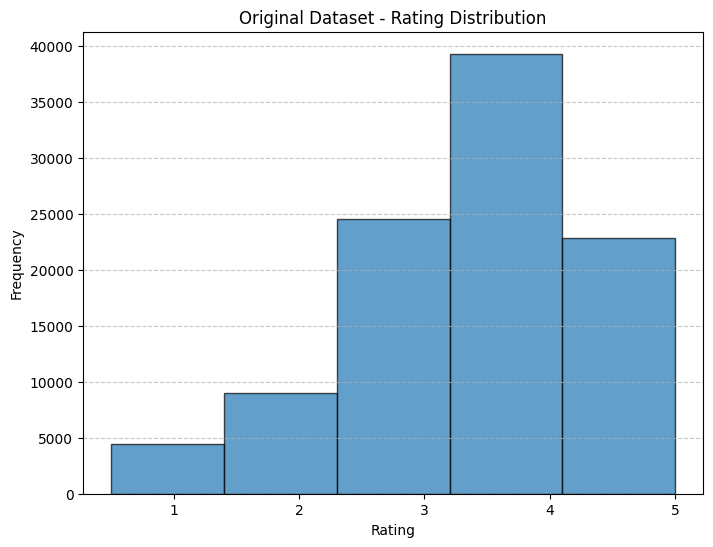

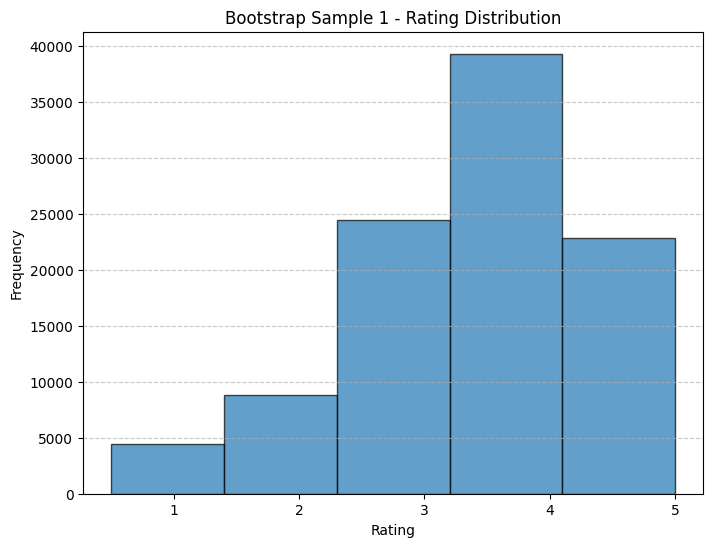

In [13]:
import matplotlib.pyplot as plt

def plot_rating_distribution(data, title):
    """
    Plot the distribution of ratings in the given dataset.

    Parameters:
    - data: DataFrame, the input data containing ratings
    - title: str, the title for the plot
    """
    plt.figure(figsize=(8, 6))
    plt.hist(data['rating'], bins=5, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the distribution of ratings in the original dataset
plot_rating_distribution(movie_lens_data, 'Original Dataset - Rating Distribution')

# Plot the distribution of ratings in each bootstrap sample
for i, bootstrap_sample in enumerate(bootstrap_samples):
    title = f'Bootstrap Sample {i + 1} - Rating Distribution'
    plot_rating_distribution(bootstrap_sample, title)
    break #to show only one
